In [2]:
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns

import os
import pandas as pd
import matplotlib.pyplot as plt
sns.set_theme()


In [3]:
# specify the directory where the CSV files are located
directory = 'data'

exclude_string = '500-10-10'#all test data was created in 2023
dfs = []
count = 0
# training_data
for filename in os.listdir(directory):
    
    if filename.endswith('.csv') and exclude_string in filename:
        # load the CSV file into a pandas DataFrame
        p = os.path.join(directory,filename)
        df = pd.read_csv(p,sep=';', decimal=",", header=None, skiprows=1)
        # do something with the DataFrame
        if len(df) != 500:
            continue
        dfs.append(df)
        
        count +=1
        if count == 500:
            break


print("Done")
num_files = len(dfs)
print(num_files)

Done
174


In [42]:
print(dfs)

[       0           1  2            3                           4
0      0  108.000000  6     0.000000       1,1,1,1,1,-1,1,1,1,-1
1      1  -12.000000  0     0.000000    -1,-1,1,1,1,-1,1,1,-1,-1
2      2  -48.999210  2     0.000790     -1,1,1,1,1,-1,1,-1,-1,1
3      3  -88.993684  4    -0.007106      -1,1,-1,1,1,1,1,1,-1,1
4      4  -51.987368  2    -0.001579   1,-1,-1,-1,-1,1,-1,1,1,-1
..   ...         ... ..          ...                         ...
495  495  -44.980262  2 -1676.585297     1,-1,1,-1,1,1,-1,1,1,-1
496  496  -88.960525  4 -1676.585297      1,-1,1,1,1,1,-1,1,1,-1
497  497  -44.992894  2 -1676.590824     1,-1,1,1,-1,1,-1,1,1,-1
498  498  -44.996842  2 -1676.594771     1,-1,1,1,-1,1,-1,1,1,-1
499  499  -44.999210  2 -1676.597140     1,-1,1,1,-1,1,-1,1,1,-1

[500 rows x 5 columns],        0           1  2            3                              4
0      0   27.992894 -2     0.000000       1,-1,1,1,-1,1,-1,-1,-1,1
1      1  -44.845344  2     0.000000        -1,1,1,-1,1,-1

In [8]:
data = np.zeros((num_files,500,10,1))

for trajectory_index in range(0,len(dfs)):
    for iteration_index in range(500):
        obj = np.array(dfs[trajectory_index].loc[iteration_index,4].split(',')).reshape((10,1))
        for line in range(10):
            for row in range(1):
                        data[trajectory_index,iteration_index,line,row] = float(obj[line,row])



                        
print("Done")


Done


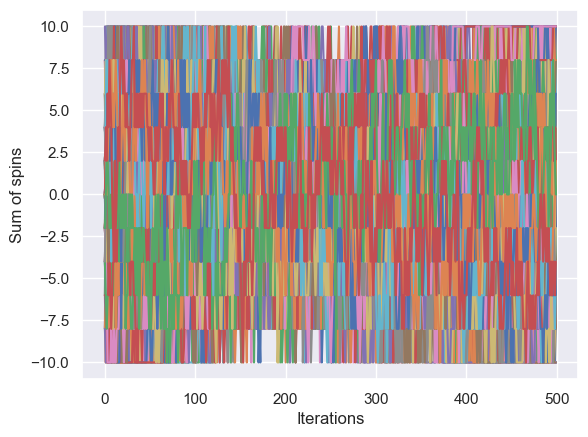

In [9]:
plt.plot(data.sum(axis=-1).sum(axis=-1).T)
plt.xlabel("Iterations")
plt.ylabel("Sum of spins")
plt.show()

In [10]:
# Here I'll create some dummy numpy data with similar dimensionality as your data

trajectories_numpy_raw = data.reshape(-1, 500, 10*1)#np.random.normal(size=(100, 500, 32, 32))
# trajectories_numpy_raw = trajectories_numpy_raw.transpose([0,2,1])

print("The data should have shape:", trajectories_numpy_raw.shape)
print("Which corresponds to [T x F x D^2]: 10 independent trajectories (T), 500 frames in each trajectory (F) for a system of size 32 x 32 (D^2)")

The data should have shape: (174, 500, 10)
Which corresponds to [T x F x D^2]: 10 independent trajectories (T), 500 frames in each trajectory (F) for a system of size 32 x 32 (D^2)


In [11]:
# lets reverse some trajectory and get labels to train on

# Draw indices to flip
toFlip = np.random.choice([0,1], size=trajectories_numpy_raw.shape[0]).astype(bool)

# flip
trajectories_numpy = trajectories_numpy_raw.copy()
trajectories_numpy[toFlip] = np.flip(trajectories_numpy[toFlip], 1)

# Create Labels
labels_numpy = np.zeros(trajectories_numpy.shape[0]).reshape(-1,1)
labels_numpy[toFlip == 0] = 1

print("\nThe labels should have shape:", labels_numpy.shape)
print("Which corresponds to [T x 1]: The one in the last dimension is VERY important, use .reshape(-1,1) if you lose it at some point.")

print("\nThe labels indicate if a trajectory is in correct direction (1) or reversed (0)")



The labels should have shape: (174, 1)
Which corresponds to [T x 1]: The one in the last dimension is VERY important, use .reshape(-1,1) if you lose it at some point.

The labels indicate if a trajectory is in correct direction (1) or reversed (0)


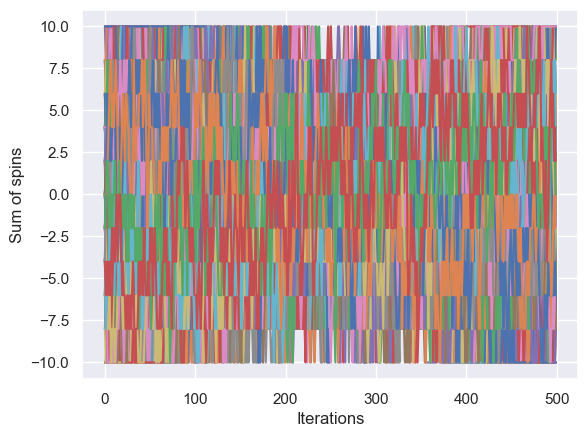

In [12]:
plt.plot(trajectories_numpy.sum(axis=-1).T)
plt.xlabel("Iterations")
plt.ylabel("Sum of spins")
plt.show()

In [13]:
# Convert to pytorch tensor

trajectories_tensor = torch.from_numpy(trajectories_numpy.astype(np.float32))
labels_tensor = torch.from_numpy(labels_numpy.astype(np.float32))


In [108]:
# Let's define some neural networks

# First up a simple feedforward network, with some hidden layers and 
# a sigmoid activation in the end to restrict the ouput between 0 and 1

class MLP(nn.Module):
    def __init__(self,  trajectory_length, N_spins, input_size, hidden_size, batch_size=64):
        super(MLP, self).__init__()
        
        self.activation = nn.ReLU()

        modules = []

        modules.append(nn.Linear(N_spins * 1, 128))
        modules.append(self.activation)
        modules.append(nn.Dropout(0.1))
        modules.append(nn.Linear(128, batch_size))
        modules.append(self.activation)
        modules.append(nn.Dropout(0.1))
        modules.append(nn.Linear(batch_size, hidden_size))
        modules.append(self.activation)
        modules.append(nn.Dropout(0.1))
        self.net = nn.Sequential(*modules)

        modules = []
        modules.append(nn.Linear(trajectory_length * hidden_size, 1))
        modules.append(nn.Sigmoid())
        self.netout = nn.Sequential(*modules)

    def forward(self, X):   

        X = self.net(X)

        X = X.reshape(X.shape[0], -1)

        return self.netout(X)



# secondly a VERY simple convolutional network with a 3x3 filter reducing 
# the frames (channels) and a linear layer for the output

class CNN(nn.Module):
    def __init__(self, trajectory_length, N_spins, N_channels_hidden = 10):
        super(CNN, self).__init__()
        
        self.activation = nn.ReLU()

        modules_cnn = []

        modules_cnn.append(nn.Conv1d(trajectory_length, N_channels_hidden, 3))
        modules_cnn.append(self.activation)
        modules_cnn.append(nn.Dropout(0.1))

        modules_cnn.append(nn.Conv1d(N_channels_hidden, 1, 3))
        modules_cnn.append(self.activation)
        modules_cnn.append(nn.Dropout(0.1))


        modules_linear = []
        modules_linear.append(nn.Linear((N_spins)*(1)-4, 1))
        modules_linear.append(nn.Sigmoid())


        self.net = nn.Sequential(*modules_cnn)
        self.linear_net = nn.Sequential(*modules_linear)

    def forward(self, X):

        X = self.net(X)

        X = X.reshape(X.shape[0], X.shape[2])
        
        return self.linear_net(X)

In [109]:
# Create a dataset
full_dataset = torch.utils.data.TensorDataset(trajectories_tensor, labels_tensor)

# Split into test and training data
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [int(len(full_dataset) * 0.8), len(full_dataset) - int(len(full_dataset) * 0.8)])

# Create a data loader for train and test sets
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False)

In [110]:

# Our train loop, very similar to the example on the pytorch website

def train_model(N_epochs, model, train_dataloader, test_dataloader):

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    loss_history = []
    for epoch in range(N_epochs):

        train_losses, test_losses = [], []

        for i, (data, labels) in enumerate(train_dataloader):
            
            optimizer.zero_grad()
            
            y_pred = model(data)

            loss = criterion(y_pred, labels )
            
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
        

        with torch.no_grad():
            
            accuracy = 0
            for i, (data, labels) in enumerate(test_dataloader):
                    
                y_pred = model(data)
                loss = criterion(y_pred, labels )

                accuracy += (y_pred.round() == labels).sum().item()
                
                test_losses.append(loss.item())

        accuracy /= len(test_dataloader.dataset)

        loss_history.append([np.average(train_losses), np.average(test_losses), accuracy])

        print("Epoch {:04d}/{}: Train Loss: {:.4f} | Test Loss: {:.4f}\tAcc.: {:.4f} ".format(epoch, N_epochs, np.average(train_losses), np.average(test_losses), accuracy))

    return np.array(loss_history)

In [133]:
arr = []
batch_sizes = [8] #[8,16,32,64]
for i in range(2,39):
    for j in range(10,11):
        for k in batch_sizes:

            # Define a model
            #model = CNN(trajectory_length=500, N_spins=32, N_channels_hidden=10)
            model = MLP(trajectory_length=500, N_spins=10, input_size=2, hidden_size=i, batch_size=k)
            # train the model for 10 epochs
            loss_history = train_model(j, model=model, train_dataloader=train_dl, test_dataloader=test_dl)
            arr.append([i,j,k, loss_history[-1]])

Epoch 0000/10: Train Loss: 0.6917 | Test Loss: 0.6877	Acc.: 0.6571 
Epoch 0001/10: Train Loss: 0.6909 | Test Loss: 0.6895	Acc.: 0.6857 
Epoch 0002/10: Train Loss: 0.6928 | Test Loss: 0.6887	Acc.: 0.6000 
Epoch 0003/10: Train Loss: 0.6915 | Test Loss: 0.6865	Acc.: 0.6000 
Epoch 0004/10: Train Loss: 0.6900 | Test Loss: 0.6891	Acc.: 0.6000 
Epoch 0005/10: Train Loss: 0.6906 | Test Loss: 0.6897	Acc.: 0.6000 
Epoch 0006/10: Train Loss: 0.6892 | Test Loss: 0.6926	Acc.: 0.4571 
Epoch 0007/10: Train Loss: 0.6916 | Test Loss: 0.6898	Acc.: 0.5714 
Epoch 0008/10: Train Loss: 0.6901 | Test Loss: 0.6918	Acc.: 0.5143 
Epoch 0009/10: Train Loss: 0.6891 | Test Loss: 0.6863	Acc.: 0.6000 
[0.68911725 0.68630767 0.6       ]


Text(0, 0.5, 'Test Accuracy')

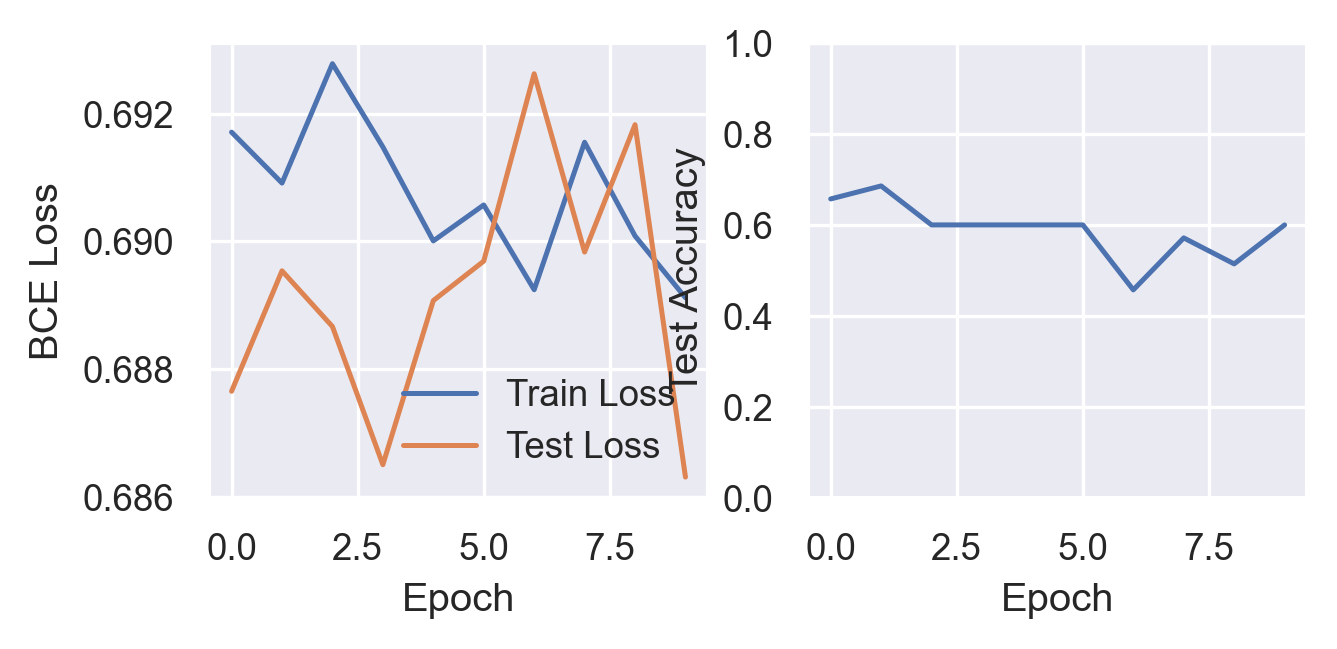

In [135]:
import matplotlib as mpl
import matplotlib.pyplot as plt
sns.set_context("paper")
mpl.rcParams.update({'font.size': 5})

fig_size = (12 * 0.393701, 5 * 0.393701) # cm -> inch: 0.393701 

fig, ax = plt.subplot_mosaic([["losses", "accuracy"]],
    
                               figsize = fig_size, dpi = 300,
                               )

ax["losses"].plot(loss_history[:,0], label="Train Loss")
ax["losses"].plot(loss_history[:,1], label="Test Loss")

ax["losses"].legend(frameon=False)
ax["losses"].set_xlabel("Epoch")
ax["losses"].set_ylabel("BCE Loss")


ax["accuracy"].plot(loss_history[:,2])

ax["accuracy"].set_ylim(0, 1)
ax["accuracy"].set_xlabel("Epoch")
ax["accuracy"].set_ylabel("Test Accuracy")